# Как строить код для машинного обучения используя Pandas & Sklearn 
based on https://github.com/DunderData/Machine-Learning-Tutorials 

В первую очередь следует установить новую версию Sklearn , начиная с 0.20.0. 
Проверьте обязательно

In [ ]:
!pip install -U scikit-learn

In [ ]:
import sklearn

In [ ]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [ ]:
sklearn.__version__

Для примера будем использовать открытый датасет from https://www.kaggle.com/c/house-prices-advanced-regression-techniques 
Файлы следует загрузить в директорию /data

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
train.head(7) 

In [ ]:
train.shape

Поставим задачу предсказания цены недвижимости по заданным параметрам - признакам (features).  
Для этого сформируем отдельный массив y из столбца SalePrice. 

In [ ]:
y = train.pop('SalePrice').values

Посмотрим как теперь выглядит исходный датафрейм

In [ ]:
train.head(7)

А теперь каков полученный массив и его первые элементы

In [ ]:
y.shape

In [ ]:
y[0:5]

Многие признаки в датафрейме имеют текстовые значения - string и необходимо выполнить их кодирование в числовые значения. Это часто называют embedding - встраивание в числовое пространство, числовое представление.
Посмотрим на один из таких столбцов признаков

In [ ]:
vc = train['HouseStyle'].value_counts()
vc

Число различных текстовых строк оказалось равным

In [ ]:
len(vc)

В Scikit-Learn каждый  estimator- оцениватель - должен работать с 2D data - сделаем это хитростью.

In [ ]:
hs_train = train[['HouseStyle']].copy()
hs_train.ndim

Импорт, активация, подгонка - трехэтапный процесс для каждого оценивателя.
Ниже мы импортируем OneHotEncoder, создаем экземпляр и гарантируем, что мы получим плотный (и не разреженный) массив, а затем закодируем наш единственный столбец с помощью метода fit_transform.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
hs_train_transformed = ohe.fit_transform(hs_train)
hs_train_transformed

Как и ожидалось, он кодировал каждое уникальное значение как свой собственный двоичный столбец.

In [ ]:
hs_train_transformed.shape

У нас есть массив NumPy. Где имена столбцов?
Обратите внимание, что наш вывод представляет собой массив NumPy, а не Pandas DataFrame. Scikit-Learn изначально не была создана для непосредственной интеграции с Pandas. Все объекты Pandas преобразуются в массивы NumPy внутри, а массивы NumPy всегда возвращаются после преобразования. 
Мы все равно можем получить имя нашего столбца из объекта OneHotEncoder с помощью метода get_feature_names!

In [ ]:
feature_names = ohe.get_feature_names()
feature_names

Проверка правильности нашей первой строки данных
Хорошо проверить, правильно ли работает наш оцениватель. Давайте посмотрим на первую строку кодированных данных.

In [ ]:
row0 = hs_train_transformed[0]
row0

In [ ]:
feature_names[row0 == 1]

Теперь давайте проверим, что первое значение в нашем исходном столбце DataFrame одинаково

In [ ]:
hs_train.values[0]

Используйте inverse_transform для автоматизации этого
Как и большинство объектов трансформатора, существует метод inverse_transform, который вернет вам исходные данные. Здесь мы должны обернуть row0 в список, чтобы сделать его двумерным массивом.

In [ ]:
ohe.inverse_transform([row0])

#### Мы можем проверить все значения, инвертируя весь преобразованный массив.

In [ ]:
hs_inv = ohe.inverse_transform(hs_train_transformed)
hs_inv

In [ ]:
np.array_equal(hs_inv, hs_train.values)

### Применение преобразования к тестовому набору
Независимо от того, какое преобразование мы делаем в нашем учебном наборе, мы должны обратиться к нашему тестовому набору. Давайте прочитаем в тестовом наборе и получим тот же столбец и применим наше преобразование.

In [ ]:
test = pd.read_csv('data/test.csv')
test.head()

In [ ]:
hs_test = test[['HouseStyle']].copy()
hs_test_transformed = ohe.transform(hs_test)
hs_test_transformed

In [ ]:
hs_test_transformed.shape

Как и ожидалось, мы снова получили восемь колонок для кодирования этого признака.

### Область проблем №1 - Категории, уникальные для тестового набора
Что произойдет, если у нас есть дом с HouseStyle, который уникален только для тестового набора? Например 3Story. Давайте изменим первое значение стилей дома и посмотрим, что такое значение по умолчанию из Scikit-Learn.

In [ ]:
hs_test = test[['HouseStyle']].copy()
hs_test.iloc[0, 0] = '3Story'
print(hs_test.head(3))

Попробуем теперь сделать эмбеддинг.

In [ ]:
ohe.transform(hs_test)

### Ошибка: Неизвестная категория
По умолчанию наш кодер выдаст ошибку. Вероятно, это то, что мы хотим, поскольку нам нужно знать, есть ли в тестовом наборе уникальные строки. Если у вас есть эта проблема, то может быть что-то гораздо более глубокое, что нужно исследовать. На данный момент мы проигнорируем эту проблему и закодируем эту строку как все 0, установив параметр handle_unknown «игнорировать» при создании экземпляра.

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(hs_train)

hs_test_transformed = ohe.transform(hs_test)
hs_test_transformed

Давайте проверим, что первая строка - все 0

In [ ]:
hs_test_transformed[0]

### Область проблем №2 - Отсутствующие значения в тестовом наборе
Если у вас отсутствуют значения в вашем тестовом наборе (NaN или None), то они будут игнорироваться до тех пор, пока для handle_unknown установлено значение «игнорировать».

In [ ]:
hs_test = test[['HouseStyle']].copy()
hs_test.iloc[0, 0] = np.nan
hs_test.iloc[1, 0] = None
print(hs_test.head(4))

In [ ]:
hs_test_transformed = ohe.transform(hs_test)
hs_test_transformed[:4]

### Область проблем №3 - Отсутствующие значения в наборе тренировок
Отсутствие значений в обучающем наборе - большая проблема. На данный момент оценка OneHotEncoder не может соответствовать отсутствующим значениям.

In [ ]:
hs_train = hs_train.copy()
hs_train.iloc[0, 0] = np.nan
hs_train.head(3)

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit_transform(hs_train)

### Нужно вводить недостающие значения
Старый Imputer из модуля предварительной обработки устарел. На его месте был сформирован новый модуль, приписываемый новым оценщиком SimpleImputer и новой стратегией «постоянный». По умолчанию использование этой стратегии будет заполнять отсутствующие значения строкой 'missing_value'. Мы можем выбрать, что установить с параметром fill_value.

In [ ]:
hs_train = train[['HouseStyle']].copy()
hs_train.iloc[0, 0] = np.nan

from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='constant', fill_value='MISSING')
hs_train_imputed = si.fit_transform(hs_train)
hs_train_imputed

Теперь мы можем кодировать, как мы это делали ранее.

In [ ]:
hs_train_transformed = ohe.fit_transform(hs_train_imputed)
hs_train_transformed

Обратите внимание, что теперь у нас есть дополнительный столбец и дополнительное имя в признаке.

In [ ]:
hs_train_transformed.shape

In [ ]:
ohe.get_feature_names()

#### Примените оба преобразования к тестовому набору
Мы можем вручную применить каждый из двух шагов выше, чтобы:

In [ ]:
hs_test = test[['HouseStyle']].copy()
hs_test.iloc[0, 0] = 'unique value to test set'
hs_test.iloc[1, 0] = np.nan

hs_test_imputed = si.transform(hs_test)
hs_test_transformed = ohe.transform(hs_test_imputed)
hs_test_transformed.shape

Почему мы применяли просто метод преобразования для тестового набора?
При преобразовании набора тестов важно просто вызвать метод преобразования, а не fit_transform. Когда мы запускали fit_transform в обучающем наборе, Scikit-Learn обнаружил всю необходимую информацию, необходимую для преобразования любого другого набора данных, содержащего одинаковые имена столбцов.

### Вместо этого используйте Pipeline - конвейер
Scikit-Learn предоставляет Pipeline transformer  и estimator, который принимает список преобразований и применяет их последовательно. Вы также можете запустить модель машинного обучения в качестве окончательной оценки. Здесь мы просто вводим и кодируем.

In [ ]:
from sklearn.pipeline import Pipeline

Каждый шаг представляет собой двухпозиционный кортеж, состоящий из строки, которая маркирует шаг и опрелитель для estimator.

In [ ]:
si_step = ('si', SimpleImputer(strategy='constant', fill_value='MISSING'))
ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
steps = [si_step, ohe_step]

pipe = Pipeline(steps)

hs_train = train[['HouseStyle']].copy()
hs_train.iloc[0, 0] = np.nan

hs_transformed = pipe.fit_transform(hs_train)
hs_transformed.shape

In [ ]:
hs_test = test[['HouseStyle']].copy()
hs_test_transformed = pipe.transform(hs_test)
hs_test_transformed.shape

### Многострочные столбцы
Кодирование нескольких столбцов строки не является проблемой. Выберите нужные столбцы, а затем снова передайте новый DataFrame по конвейеру.

In [ ]:
string_cols = ['RoofMatl', 'HouseStyle']
string_train = train[string_cols]
print(string_train.head(3))

In [ ]:
string_train_transformed = pipe.fit_transform(string_train)
string_train_transformed.shape

#### Получение отдельных фрагментов конвейера

In [ ]:
ohe = pipe.named_steps['ohe']
ohe.get_feature_names()

### Используйте новый ColumnTransformer для выбора столбцов
Новый ColumnTransformer (часть нового модуля компоновки) позволяет вам выбирать, какие столбцы получают, какие преобразования. Категориальные столбцы почти всегда будут нуждаться в отдельных преобразованиях, чем числовые столбцы.

 ColumnTransformer берет список кортежей из трех элементов. Первое значение в кортеже - это имя, которое его маркирует, второе представляет собой экземплярную оценку, а третий - список столбцов, к которым вы хотите применить преобразование. Кортеж будет выглядеть так:

('name', SomeTransformer (параметры), столбцы)

В столбцах фактически нет имен столбцов. Вместо этого вы можете использовать целые индексы столбцов, булевский массив или даже функцию (которая принимает весь DataFrame в качестве аргумента и должна возвращать выбор столбцов).
Мы можем даже передать конвейер многих преобразований в преобразователь столбцов, потому что у нас есть несколько преобразований в наших строковых столбцах.

In [ ]:
from sklearn.compose import ColumnTransformer

cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]

cat_pipe = Pipeline(cat_steps)
cat_cols = ['RoofMatl', 'HouseStyle']
cat_transformers = [('cat', cat_pipe, cat_cols)]

ct = ColumnTransformer(transformers=cat_transformers)

### Передача всего DataFrame в ColumnTransformer
Экземпляр ColumnTransformer выбирает столбцы, которые мы хотим использовать, поэтому мы просто передаем весь DataFrame методу fit_transform. Для нас будут выбраны нужные столбцы.

In [ ]:
X_cat_transformed = ct.fit_transform(train)
X_cat_transformed

In [ ]:
X_cat_transformed.shape

Теперь мы можем преобразовать наш тестовый набор таким же образом.

In [ ]:
X_cat_transformed_test = ct.transform(test)
X_cat_transformed_test.shape

### Получение названий функций
Все трансформаторы хранятся в атрибуте слова named_transformers_. Затем мы используем имена, первый элемент из кортежа из трех элементов, чтобы выбрать конкретный трансформатор. Ниже мы выбираем наш трансформатор (здесь есть только один - конвейер с именем «cat»).

In [ ]:
pl = ct.named_transformers_['cat']

Затем из этого конвейера мы выбираем объект one-hot encoder и, наконец, получаем имена функций.

In [ ]:
ohe = pl.named_steps['ohe']
ohe.get_feature_names()

### Преобразование числовых столбцов
Числовым столбцам будет нужен другой набор преобразований. Вместо того, чтобы вменять пропущенные значения с константой, часто выбирают медианную или среднюю. И вместо кодирования значений мы обычно стандартизируем их путем вычитания среднего значения каждого столбца и деления на стандартное отклонение. Это полезно для  многих моделей, таким как регрессия. 



Вместо того, чтобы выбирать только один или два столбца вручную, как мы это делали выше, со строковыми столбцами, мы можем выбрать все числовые столбцы. Мы делаем это, сначала определяя тип данных каждого столбца с атрибутом dtypes, а затем проверяем, является ли тип каждого dtype «O». Атрибут dtypes возвращает объект NumPy dtype. Каждый из них имеет атрибут вида, который является единственным символом. Мы можем использовать это, чтобы найти числовые или строковые столбцы. Pandas хранит все свои строковые столбцы как объекты, которые имеют вид, равный «O».

In [ ]:
train.dtypes.head()

Получим сорта, одну строку символов, представляющую dtype.

In [ ]:
kinds = np.array([dt.kind for dt in train.dtypes])
kinds[:5]

Предположим, что все числовые столбцы не являются объектами.

In [ ]:
all_columns = train.columns.values
is_num = kinds != 'O'
num_cols = all_columns[is_num]
num_cols[:5]

In [ ]:
cat_cols = all_columns[~is_num]
cat_cols[:5]

После того, как у нас есть числовые имена столбцов, мы снова сможем использовать ColumnTransformer.

In [ ]:
from sklearn.preprocessing import StandardScaler

num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step, num_ss_step]

num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]

ct = ColumnTransformer(transformers=num_transformers)

X_num_transformed = ct.fit_transform(train)
X_num_transformed.shape

#### Сочетание как категориальных, так и числовых преобразований столбцов
Мы можем применять отдельные преобразования к каждому разделу нашего DataFrame с помощью ColumnTransformer. В этом примере мы будем использовать каждый столбец.

Затем мы создаем отдельный конвейер для категориальных и числовых столбцов, а затем используйте ColumnTransformer для их независимого преобразования. Эти две трансформации происходят параллельно. Результаты каждого из них затем объединяются вместе.

In [ ]:
transformers = [('cat', cat_pipe, cat_cols),
                ('num', num_pipe, num_cols)]

ct = ColumnTransformer(transformers=transformers)

X = ct.fit_transform(train)
X.shape

## Машинное обучение
Весь смысл предыдущих шагов - подготовить наши данные, чтобы передать их для модели машинного обучения. Мы можем создать один окончательный конвейер и добавить модель машинного обучения в качестве окончательной оценки. Первым шагом в конвейере будет полное преобразование, которое мы только что сделали выше. Мы выбрали задачу предсказания SalePrice. Здесь мы просто используем метод fit вместо fit_transform, так как наш последний шаг - модель машинного обучения и не делает преобразований.

In [ ]:
from sklearn.linear_model import Ridge

ml_pipe = Pipeline([('transform', ct), ('ridge', Ridge())])
ml_pipe.fit(train, y)

In [ ]:
ml_pipe.score(train, y)

#### Cross Validation
Конечно, проверять на тренировочном наборе бесполезно. Давайте сделаем несколько перекрестных проверок K-fold, чтобы получить представление о том, насколько хорошо мы будем делать с невидимыми данными. Мы устанавливаем случайное состояние так, чтобы расщепления были одинаковыми во всем остальном учебнике.
http://www.long-short.pro/post/kross-validatsiya-cross-validation-304 

Кросс-валидация, которую иногда называют перекрестной проверкой, это техника валидации модели для проверки того, насколько успешно применяемый в модели статистический анализ способен работать на независимом наборе данных. Обычно кросс-валидация используется в ситуациях, где целью является предсказание, и хотелось бы оценить, насколько предсказывающая модель способна работать на практике. Один цикл кросс-валидации включает разбиение набора данных на части, затем построение модели на одной части (называемой тренировочным набором), и валидация модели на другой части (называемой тестовым набором). Чтобы уменьшить разброс результатов, разные циклы кросс-валидации проводятся на разных разбиениях, а результаты валидации усредняются по всем циклам. 

#### Кросс-валидация по K блокам (K-fold cross-validation) 


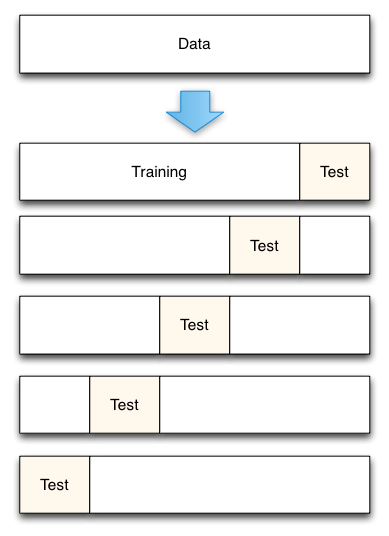

В этом случае исходый набор данных разбивается на K одинаковых по размеру блока. Из K блоков один оставляется для тестирования модели, а остающиеся K-1 блока используются как тренировочный набор. Процесс повторяется K раз, и каждый из блоков используется один раз как тестовый набор. Получаются K результатов, по одному на каждый блок, они усредняются или комбинируются каким-либо другим способом, и дают одну оценку.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=123)


cross_val_score(ml_pipe, train, y, cv=kf).mean()

In [ ]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Выбор параметров с помощью Grid Searching
Grid Searching в Scikit-Learn требует, чтобы мы передавали словарь имен параметров, сопоставленных с возможными значениями. При использовании конвейера мы должны использовать имя шага, за которым следует двойное подчеркивание, а затем имя параметра. Если в вашем конвейере есть несколько уровней, как мы здесь, мы должны продолжать использовать двойные подчеркивания для перехода на уровень до тех пор, пока не получим оценку, параметры которой мы хотели бы оптимизировать.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'transform__num__si__strategy': ['mean', 'median'],
    'ridge__alpha': [.001, 0.1, 1.0, 5, 10, 50, 100, 1000],
}
gs = GridSearchCV(ml_pipe, param_grid, cv=kf)

In [ ]:
gs.fit(train, y)
gs.best_params_

In [ ]:
gs.best_score_

#### Получение всех результатов поиска параметров  в Pandas DataFrame
Все результаты поиска наилучших параметров хранятся в атрибуте cv_results_. Это словарь, который может быть преобразован в Pandas DataFrame для приятного отображения и предоставляет структуру, которая намного проще для сканирования вручную.

In [ ]:
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200

In [ ]:
pd.DataFrame(gs.cv_results_)

# End of Slides